In [159]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
from scipy.spatial import KDTree

In [2]:
def pairwise_func(x, y):
    if np.linalg.norm(x - y) > 1:
        return 0
    return (1 - (x - y) @ (x - y)) ** 2

In [3]:
def pairwise_dists(X):
    squared_norms = np.sum(X**2, axis=1)
    pairwise_sq_dist = squared_norms[:, np.newaxis] + squared_norms - 2 * X @ X.T
    return np.sqrt(pairwise_sq_dist)

In [4]:
def func_old(X):
    # TODO make it numpyic
    ans = 0
    for i in range(len(X)):
        for j in range(i + 1, len(X)):
            ans += pairwise_func(X[i], X[j])
    return ans

In [5]:
def func(X):
    squared_norms = np.sum(X**2, axis=1)
    squared_dists = squared_norms[:, np.newaxis] + squared_norms - 2 * X @ X.T
    squared_dists = np.minimum(squared_dists, 1)
    potentials = (1 - squared_dists)**2
    return (np.sum(potentials) - X.shape[0]) / 2

In [6]:
def pairwise_grad(x, y):
    # gradient with respect to x
    if np.linalg.norm(x - y) > 1:
        return np.zeros_like(x)
    return - 4 * (1 - (x - y) @ (x - y)) * (x - y)

In [7]:
def grad_old(X):
    # TODO numpyify
    ans = []
    for i in range(len(X)):
        next_grad = 0
        for j in range(len(X)):
            if i != j:
                next_grad = next_grad + pairwise_grad(X[i], X[j])
        ans.append(next_grad.copy())

    return np.array(ans)

In [8]:
def grad(X):
    squared_norms = np.sum(X**2, axis=1)
    squared_dists = squared_norms[:, np.newaxis] + squared_norms - 2 * X @ X.T
    squared_dists = np.minimum(squared_dists, 1)
    multipliers = 4 * (squared_dists - 1)
    
    differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]
    grads = differences * multipliers[:, :, np.newaxis]
    return np.sum(grads, axis=1)

In [78]:
def grad_kdtree(X, inds):
    differences = X[:, np.newaxis, :] - X[inds[:, 1:]]
    
    dists = np.minimum(np.linalg.norm(differences, axis=2), 1)
    multipliers = 4 * (dists**2 - 1)
    
    grads = differences * multipliers[:, :, np.newaxis]
    return np.sum(grads, axis=1)

In [10]:
def renorm(X):
    # makes X[i] unit norm
    row_norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / row_norms

In [11]:
def gd(grad, x0, num_iter, tol, alpha):
    x = x0.copy()
    conv = [x.copy()]
    for iter_idx in range(num_iter):
        g = grad(x)
        next_x = renorm(x - alpha * g)
        if np.linalg.norm((next_x - x) / alpha) < tol:
            break
        x = next_x
        conv.append(x.copy())
    return x, conv

In [12]:
def heavy_ball(grad, x0, num_iter, tol, alpha, beta):
    x = x0.copy()
    conv = [x.copy()]
    for iter_idx in range(num_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break
        if len(conv) > 1:
            next_x = renorm(x - alpha * g + beta * (x - conv[-2]))
        else:
            next_x = renorm(x - alpha * g)

        if np.linalg.norm((next_x - x) / alpha) < tol:
            break
        x = next_x
        conv.append(x.copy())
    return x, conv

In [13]:
def accelerated_gradient(func, grad, x0, num_iter, tol, alpha, restart=False, adapt_step=False, alpha_min=1e-3):
    x = x0.copy()
    y = x0.copy()
    conv = [x.copy()]
    k = 0
    for iter_idx in range(num_iter):
        x_next = y - alpha * grad(y)
        grad_x = grad(x)
        if restart and func(x) < func(renorm(x_next)):
            if adapt_step and alpha > alpha_min:
                if func(x) < func(renorm(x - alpha * grad_x)):
                    alpha = alpha * 0.8
            x_next = x - alpha * grad_x
            k = 0
        y = x_next + (k + 1) / (k + 4) * (x_next - x)
        y = renorm(y)
        x_next = renorm(x_next)
        if np.linalg.norm((x - x_next) / alpha) < tol:
            break
        x = x_next.copy()
        g = grad(x)
        conv.append(x.copy())
        k += 1
    return x, conv

In [14]:
def accelerated_gradient_kdt(func, x0, recomp_tree, num_neighbors, num_iter, tol, alpha, restart=False, adapt_step=False, alpha_min=1e-3):
    x = x0.copy()
    y = x0.copy()
    conv = [x.copy()]
    k = 0

    tree = KDTree(x)
    dists, inds = tree.query(x, k=num_neighbors)
    
    for iter_idx in range(num_iter):
        if iter_idx % recomp_tree == 0:
            tree = KDTree(x)
            dists, inds = tree.query(x, k=num_neighbors)
        
        x_next = y - alpha * grad_kdtree(y, inds)
        grad_x = grad_kdtree(x, inds)
        if restart and func(x) < func(renorm(x_next)):
            if adapt_step and alpha > alpha_min:
                if func(x) < func(renorm(x - alpha * grad_x)):
                    alpha = alpha * 0.8
            x_next = x - alpha * grad_x
            k = 0
        y = x_next + (k + 1) / (k + 4) * (x_next - x)
        y = renorm(y)
        x_next = renorm(x_next)
        if np.linalg.norm((x - x_next) / alpha) < tol:
            break
        x = x_next.copy()
        g = grad_kdtree(x, inds)
        conv.append(x.copy())
        k += 1
    return x, conv

In [15]:
def grad_projection_norm(X):
    g = grad(X)
    return np.linalg.norm(renorm(X + g) - X)

In [149]:
n = 11
N = 500
X0 = renorm(np.random.randn(N,n))

In [150]:
alpha = 0.003
beta = 0.9
num_iter = 500
tol = 1e-6

In [151]:
%%time
x_gd, conv_gd = gd(grad, X0, num_iter, tol, alpha)

CPU times: user 2min 10s, sys: 7.16 s, total: 2min 17s
Wall time: 17.9 s


In [152]:
%%time
x_hb, conv_hb = heavy_ball(grad, X0, num_iter, tol, alpha, beta)

CPU times: user 2min 11s, sys: 7.83 s, total: 2min 19s
Wall time: 17.7 s


In [153]:
%%time
x_ag, conv_ag = accelerated_gradient(func, grad, X0, num_iter, tol, alpha)

CPU times: user 6min 51s, sys: 23.4 s, total: 7min 14s
Wall time: 55.6 s


In [154]:
%time x_agkd, conv_agkd = accelerated_gradient_kdt(func, X0, 10, 50, num_iter, tol, alpha, restart=True, adapt_step=True, alpha_min=1e-3)

CPU times: user 1min 8s, sys: 34.6 ms, total: 1min 8s
Wall time: 8.61 s


In [155]:
%%time
x_agr, conv_agr = accelerated_gradient(func, grad, X0, num_iter, tol, alpha, restart=True)

CPU times: user 7min 4s, sys: 24 s, total: 7min 28s
Wall time: 56.8 s


In [156]:
%%time
x_agra, conv_agra = accelerated_gradient(func, grad, X0, num_iter, tol, alpha, restart=True, adapt_step=True)

CPU times: user 7min 10s, sys: 23.9 s, total: 7min 34s
Wall time: 58.1 s


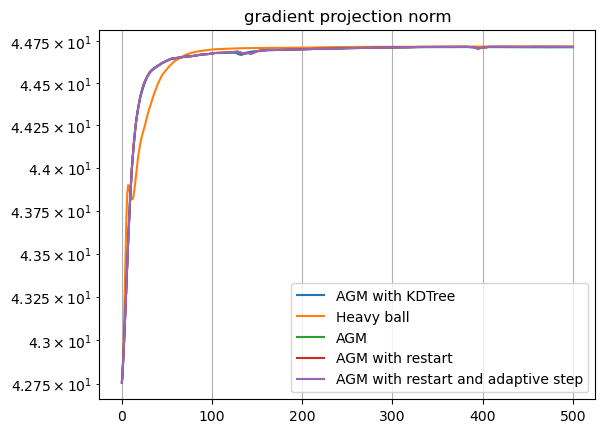

In [157]:
plt.semilogy([grad_projection_norm(x) for x in conv_agkd], label="AGM with KDTree")
plt.semilogy([grad_projection_norm(x) for x in conv_hb], label="Heavy ball")
plt.semilogy([grad_projection_norm(x) for x in conv_ag], label="AGM")
plt.semilogy([grad_projection_norm(x) for x in conv_agr], label="AGM with restart")
plt.semilogy([grad_projection_norm(x) for x in conv_agra], label="AGM with restart and adaptive step")
plt.title("gradient projection norm")
plt.legend()
plt.grid(True)

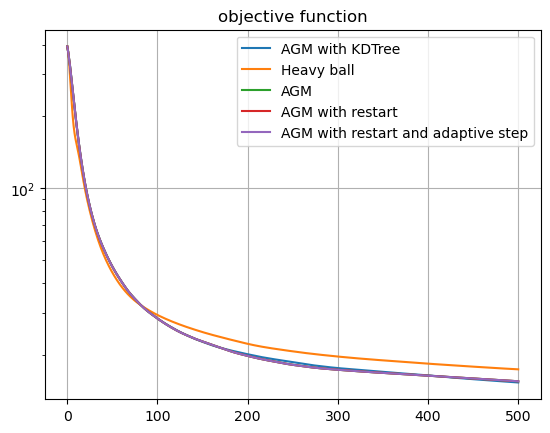

In [158]:
plt.semilogy([func(x) for x in conv_agkd], label="AGM with KDTree")
plt.semilogy([func(x) for x in conv_hb], label="Heavy ball")
plt.semilogy([func(x) for x in conv_ag], label="AGM")
plt.semilogy([func(x) for x in conv_agr], label="AGM with restart")
plt.semilogy([func(x) for x in conv_agra], label="AGM with restart and adaptive step")
plt.title("objective function")
plt.legend()
plt.grid(True)

In [27]:
n = 2
N = 5
X0 = renorm(np.random.randn(N,n))
X0

array([[-0.93567351, -0.35286695],
       [-0.94402964, -0.32986064],
       [ 0.67580525, -0.73708022],
       [-0.28618905, -0.95817317],
       [ 0.94333805,  0.33183328]])

In [28]:
tree = KDTree(X0)
dists, inds = tree.query(X0, k=4)
dists, inds

(array([[0.        , 0.02447683, 0.88782075, 1.65664832],
        [0.        , 0.02447683, 0.90968724, 1.67023737],
        [0.        , 0.98707403, 1.1018847 , 1.65664832],
        [0.        , 0.88782075, 0.90968724, 0.98707403],
        [0.        , 1.1018847 , 1.78209246, 1.99987471]]),
 array([[0, 1, 3, 2],
        [1, 0, 3, 2],
        [2, 3, 4, 0],
        [3, 0, 1, 2],
        [4, 2, 3, 0]]))

In [29]:
directions = X0[inds[:, 1:]] - X0[:, np.newaxis, :]
directions, np.linalg.norm(directions, axis=2)

(array([[[-0.00835613,  0.02300631],
         [ 0.64948446, -0.60530622],
         [ 1.61147876, -0.38421327]],
 
        [[ 0.00835613, -0.02300631],
         [ 0.65784059, -0.62831253],
         [ 1.61983489, -0.40721959]],
 
        [[-0.96199431, -0.22109295],
         [ 0.26753279,  1.06891351],
         [-1.61147876,  0.38421327]],
 
        [[-0.64948446,  0.60530622],
         [-0.65784059,  0.62831253],
         [ 0.96199431,  0.22109295]],
 
        [[-0.26753279, -1.06891351],
         [-1.2295271 , -1.29000645],
         [-1.87901156, -0.68470023]]]),
 array([[0.02447683, 0.88782075, 1.65664832],
        [0.02447683, 0.90968724, 1.67023737],
        [0.98707403, 1.1018847 , 1.65664832],
        [0.88782075, 0.90968724, 0.98707403],
        [1.1018847 , 1.78209246, 1.99987471]]))

(-1.1, 1.1)

<Figure size 700x700 with 0 Axes>

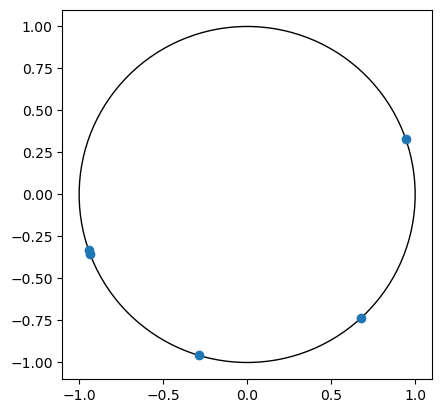

In [30]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0, 0), 1, fill=False)
ax.add_patch(circle)
plt.scatter(X0[:,0], X0[:,1])
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [31]:
def optimize_by_centering(X0, max_iter, tol):
    # not stable
    
    x = X0.copy()

    for _ in range(max_iter):
        tree = KDTree(x)
        dists, inds = tree.query(x, k=x.shape[1] + 1)
        
        x_next = x.copy()
        for i in range(len(x)):
            if dists[i,1] < 1:
                x_next[i] = np.linalg.solve(x[inds[i,1:]], np.ones(x.shape[1]))
                # if x[i] was not inside the cone spanned by its neighbors, then move it in the opposite direction
                if np.any(np.linalg.solve(x[inds[i,1:]].T, x[i]) < 0):
                    x_next[i] = x[i] + 0.1 * (x[i] - x_next[i])

        x_next = renorm(x_next)
        if np.linalg.norm(x - x_next) < tol:
            break
        x = x_next

    return x

In [32]:
x = optimize_by_centering(X0, 100, 1e-6)

(-1.1, 1.1)

<Figure size 700x700 with 0 Axes>

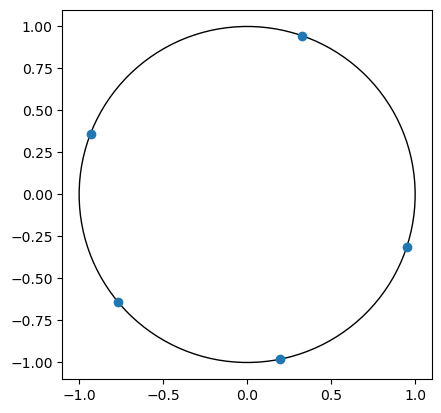

In [33]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0, 0), 1, fill=False)
ax.add_patch(circle)
plt.scatter(x[:,0], x[:,1])
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [34]:
n = 6
N = 70
X0 = renorm(np.random.randn(N,n))

In [148]:
%%time
x = optimize_by_centering(X0, 500, 1e-6)
func(x)

CPU times: user 3.01 s, sys: 1.22 ms, total: 3.01 s
Wall time: 3 s


np.float64(63.3197812988941)